# Fraud Analysis - Cloudwalk Case

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
# Taking a look at the data
data = pd.read_csv('transactional-sample.csv')

data.head(3)

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk
0,21320398,29744,97051,434505******9116,2019-12-01T23:16:32.812632,374.56,285475.0,False
1,21320399,92895,2708,444456******4210,2019-12-01T22:45:37.873639,734.87,497105.0,True
2,21320400,47759,14777,425850******7024,2019-12-01T22:22:43.021495,760.36,NaN,False


## EDA - Exploratory Data Analysis

### Understanding the data better

#### Dataset Structure

**Key observations**
* The dataset has **3199** transactions with **8** columns.
* The only column with missing values is **`device_id`**.
* The dataset has no duplicated values
* The transactions happend between **2019-11-01 01:27:15** and **2019-12-01 23:16:32**

**Column descriptions:**

* **`transaction_id`**: Unique identifier for each transaction (*int64*).
* **`merchant_id`**: Unique identifier for each merchant (*int64*).
* **`user_id`**: Unique identifier for each customer (*int64*).
* **`card_number`**: The card number used for the transaction (*object*).
* **`transaction_date`**: The date when the transaction ocurred (*object*).
* **`transaction_amount`**: The amount spent in the transaction (*float64*).
* **`device_id`**: Unique identifier of the device used for the transaction (*float64*), with 830 missing values.
* **`has_cbk`**: Boolean flag indicating if the transaction resulted in a chargeback (*bool*). Containing **2080** transactions without fraud chargeback and **391** with fraud chargeback.

**Closer look in the identification columns:**

* **`merchant_id`**: **1756** unique merchants.
* **`user_id`**: **2704** unique users.
* **`device_id`** **1996** unique devices.

In [3]:
print(f"Number of transactions: {len(data)}.")
print('-'*150)
print(f"Columns in the dataset {list(data.columns)}.")

Number of transactions: 3199.
------------------------------------------------------------------------------------------------------------------------------------------------------
Columns in the dataset ['transaction_id', 'merchant_id', 'user_id', 'card_number', 'transaction_date', 'transaction_amount', 'device_id', 'has_cbk'].


In [4]:
data.info() # Taking a look general informations about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_id      3199 non-null   int64  
 1   merchant_id         3199 non-null   int64  
 2   user_id             3199 non-null   int64  
 3   card_number         3199 non-null   object 
 4   transaction_date    3199 non-null   object 
 5   transaction_amount  3199 non-null   float64
 6   device_id           2369 non-null   float64
 7   has_cbk             3199 non-null   bool   
dtypes: bool(1), float64(2), int64(3), object(2)
memory usage: 178.2+ KB


In [5]:
data.isna().sum() # Checking for missing values

transaction_id          0
merchant_id             0
user_id                 0
card_number             0
transaction_date        0
transaction_amount      0
device_id             830
has_cbk                 0
dtype: int64

In [6]:
data.duplicated().sum() # Checking for duplicates

np.int64(0)

In [7]:
# It looks like the date column is a Object type, let's transform it to a datetime.
data['transaction_date'] = pd.to_datetime(data['transaction_date'], format="%Y-%m-%dT%H:%M:%S.%f")

print(f"Data type of the transaction_date column after transformation: {data['transaction_date'].dtype}")

print(f"First day of transaction sample: {data['transaction_date'].min()}.")
print(f"Last day of transaction sample: {data['transaction_date'].max()}.")

Data type of the transaction_date column after transformation: datetime64[ns]
First day of transaction sample: 2019-11-01 01:27:15.811098.
Last day of transaction sample: 2019-12-01 23:16:32.812632.


has_cbk
False    2808
True      391
Name: count, dtype: int64


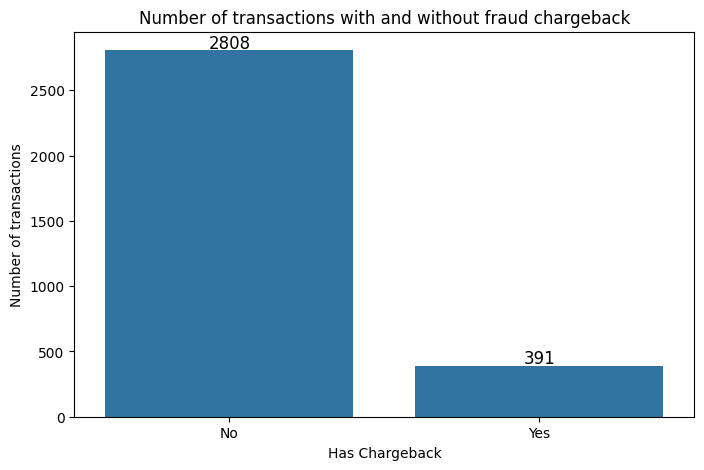

In [8]:
print(data['has_cbk'].value_counts())

fig = plt.figure(figsize=(8, 5))
ax = sns.barplot(x=data['has_cbk'], y=data['has_cbk'].value_counts())

plt.title('Number of transactions with and without fraud chargeback')
plt.ylabel('Number of transactions')
plt.xlabel('Has Chargeback')

plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.show()

In [9]:
# checking for unique values in identification columns
for col in ['merchant_id', 'user_id', 'device_id']:
    print(f"{col}: {data[col].nunique()} unique values.")

merchant_id: 1756 unique values.
user_id: 2704 unique values.
device_id: 1996 unique values.


#### Statistical Analysis

**`transaction amount` Summary statisticas**:

* **Count**: The dataset contains **3199** transactions
* **Mean**: The average transaction amount is **$767.81**
* **Std dev**: A high standard deviation (**$889.10**) indicates significant variability in transaction amounts.
* **Min**: The smallest transaction recorded is **$1.22**
* **25% (First Quartile)**: 25% of transactions are below **$205.23**.
* **50% (Median)**: The middle transaction amount is **$415.94**.
* **75% (Third Quartile)**: 75% of transactions are below **$981.68**.
* **Max**: The largest transaction recorded is **$4097.21**.

In [10]:
print(data['transaction_amount'].describe()) # Taking a look at the basic statistics of the transaction amount column

count    3199.000000
mean      767.812904
std       889.095904
min         1.220000
25%       205.235000
50%       415.940000
75%       981.680000
max      4097.210000
Name: transaction_amount, dtype: float64


#### Distribution and pattern analysis

In [ ]:
fraudulent_transactions = data[data['has_cbk']==True]
non_fraudulent_transactions = data[data['has_cbk']==False]

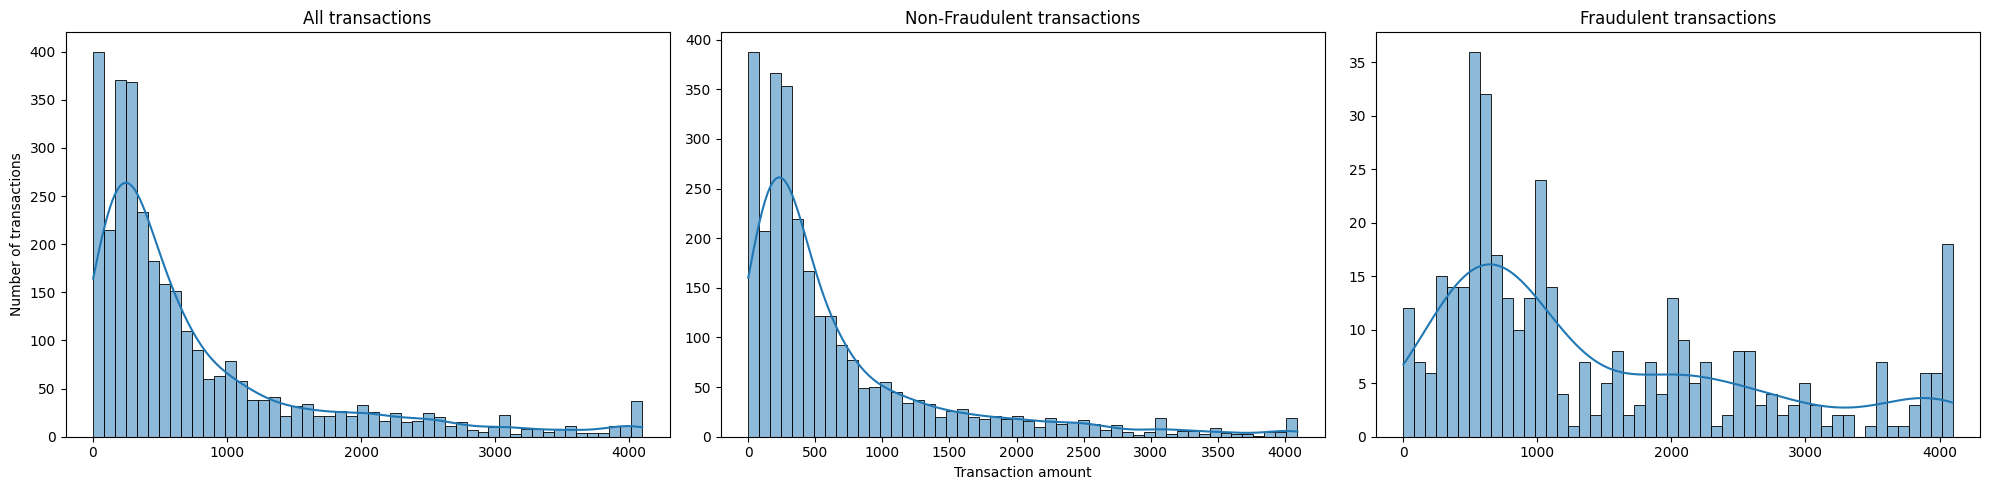

In [33]:
# Creating a function to plot the distribution of the transaction amount
def plot_transaction_amount_dist(data, ax=None, figsize=(8, 5)):
    sns.histplot(data['transaction_amount'], bins=50, kde=True, ax=ax)

# Plotting the distribution of the transaction amount
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plotting the distribution of the transaction amount for all transactions
plot_transaction_amount_dist(data, ax=axes[0])
axes[0].set_title("All transactions")
axes[0].set_xlabel("")
axes[0].set_ylabel("Number of transactions")

# Plotting the distribution of the transaction amount for non-fraudulent transactions
plot_transaction_amount_dist(non_fraudulent_transactions, ax=axes[1])
axes[1].set_title("Non-Fraudulent transactions")
axes[1].set_xlabel("Transaction amount")
axes[1].set_ylabel("")

# Plotting the distribution of the transaction amount for fraudulent transactions
plot_transaction_amount_dist(fraudulent_transactions, ax=axes[2])
axes[2].set_title("Fraudulent transactions")
axes[2].set_xlabel("")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()

In [49]:
# Getting some statistics about the fraudulent transactions
print("Mean comparison between all transactions, fraudulent and non-fraudulent transactions:")
print(f"All transactions: {round(fraudulent_transactions['transaction_amount'].mean(), 3)}")
print(f"Non-fraudulent transactions: {round(non_fraudulent_transactions['transaction_amount'].mean(), 3)}")
print(f"Fraudulent transactions: {round(data['transaction_amount'].mean(), 3)}")

print("-"*100)

print("Standard deviation comparison between all transactions, fraudulent and non-fraudulent transactions:")
print(f"All transactions: {round(fraudulent_transactions['transaction_amount'].std(), 3)}")
print(f"Non-fraudulent transactions: {round(non_fraudulent_transactions['transaction_amount'].std(), 3)}")
print(f"Fraudulent transactions: {round(data['transaction_amount'].std(), 3)}")


Mean comparison between all transactions, fraudulent and non-fraudulent transactions:
All transactions: 1453.572
Non-fraudulent transactions: 672.324
Fraudulent transactions: 767.813
----------------------------------------------------------------------------------------------------
Standard deviation comparison between all transactions, fraudulent and non-fraudulent transactions:
All transactions: 1169.491
Non-fraudulent transactions: 797.464
Fraudulent transactions: 889.096


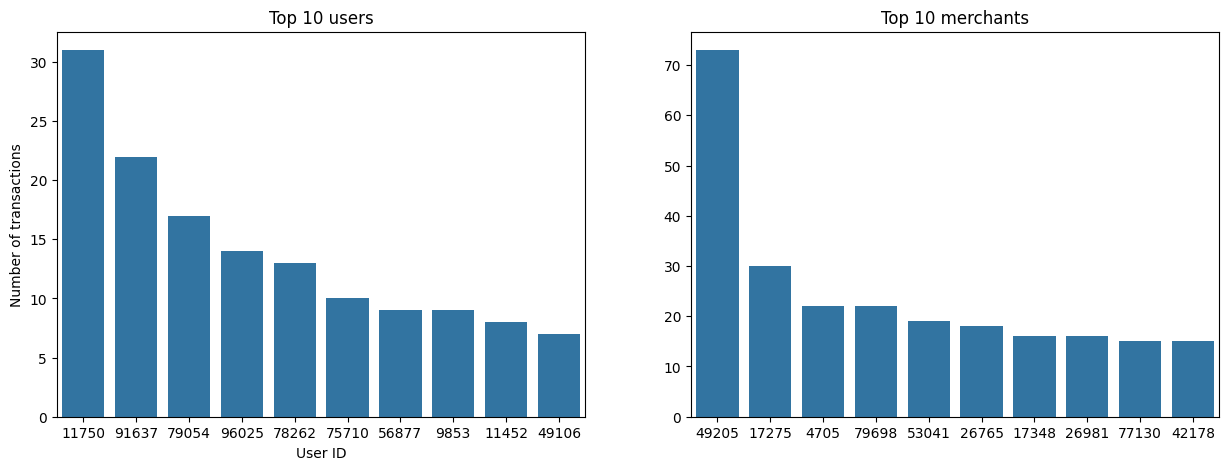

In [12]:
top_10_users = data['user_id'].value_counts().sort_values(ascending=False).head(10)
top_10_merchants = data['merchant_id'].value_counts().sort_values(ascending=False).head(10)

def plot_top_10(data, ax=None):
    sns.barplot(x=data.index, y=data.values, order=data.index, ax=ax)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_top_10(top_10_users, ax=axes[0])
axes[0].set_title("Top 10 users")
axes[0].set_xlabel("User ID")
axes[0].set_ylabel("Number of transactions")

plot_top_10(top_10_merchants, ax=axes[1])
axes[1].set_title("Top 10 merchants")
axes[1].set_xlabel("")
axes[1].set_ylabel("")

plt.show()

In [45]:
print("Top 3 users with more transactions:")
for i, j in zip(top_10_users.index[:3], top_10_users.values[:3]):
    print(f"User ID: {i} - Number of transactions: {j}")

print("-"*50)

print("Top 3 merchants with more transactions:")
for n, m in zip(top_10_merchants.index[:3], top_10_merchants.values[:3]):
    print(f"Merchant ID: {n} - Number of transactions: {m}")

Top 3 users with more transactions:
User ID: 11750 - Number of transactions: 31
User ID: 91637 - Number of transactions: 22
User ID: 79054 - Number of transactions: 17
--------------------------------------------------
Top 3 merchants with more transactions:
Merchant ID: 49205 - Number of transactions: 73
Merchant ID: 17275 - Number of transactions: 30
Merchant ID: 4705 - Number of transactions: 22


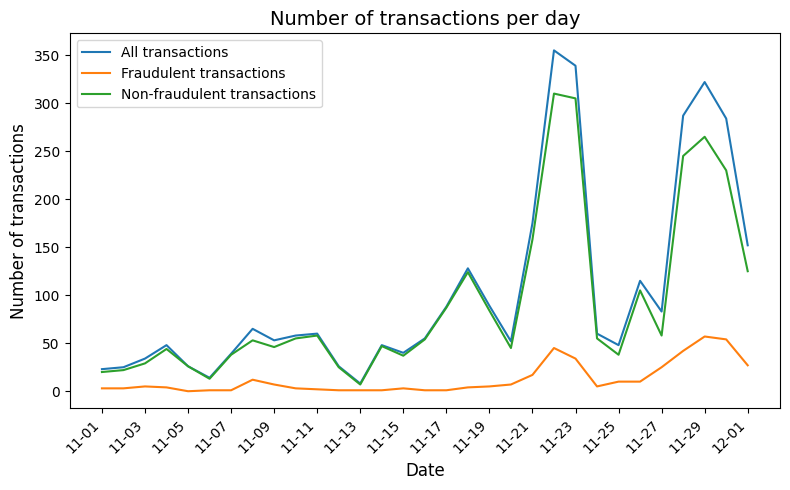

In [59]:
# Number of transactions per day
transaction_per_day = data.set_index('transaction_date').resample('D').count()['transaction_id']
fraudulent_transactions_per_day = fraudulent_transactions.set_index('transaction_date').resample('D').count()['transaction_id']
non_fraudulent_transactions_per_day = non_fraudulent_transactions.set_index('transaction_date').resample('D').count()['transaction_id']

# Plotting the number of transactions per day
plt.figure(figsize=(8, 5))

sns.lineplot(x=transaction_per_day.index, y=transaction_per_day.values, label='All transactions')
sns.lineplot(x=fraudulent_transactions_per_day.index, y=fraudulent_transactions_per_day.values, label='Fraudulent transactions')
sns.lineplot(x=non_fraudulent_transactions_per_day.index, y=non_fraudulent_transactions_per_day.values, label='Non-fraudulent transactions')

plt.title("Number of transactions per day", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of transactions", fontsize=12)
plt.xticks(rotation=45, ha='right')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

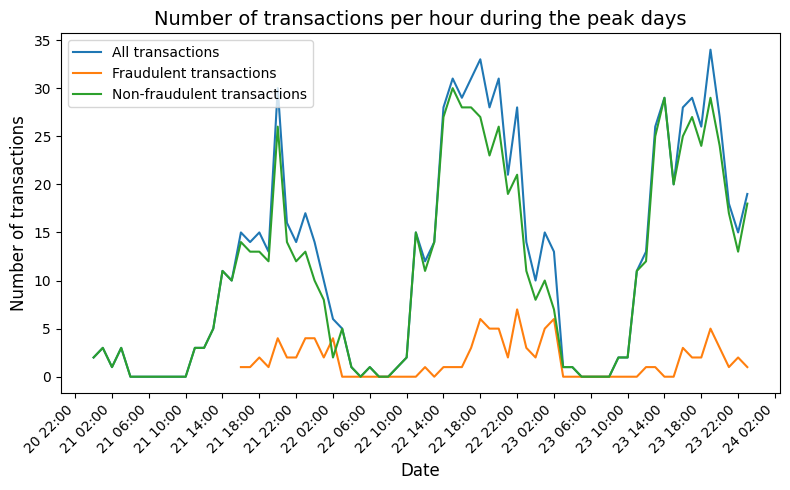

In [71]:
data_peak = data[(data['transaction_date'] >= '2019-11-21') & (data['transaction_date'] <= '2019-11-24')]
fraudulent_data_peak = fraudulent_transactions[(fraudulent_transactions['transaction_date'] >= '2019-11-21') & (fraudulent_transactions['transaction_date'] <= '2019-11-24')]
non_fraudulent_data_peak = non_fraudulent_transactions[(non_fraudulent_transactions['transaction_date'] >= '2019-11-21') & (non_fraudulent_transactions['transaction_date'] <= '2019-11-24')]

# Number of transactions per day
transaction_per_day_peak = data_peak.set_index('transaction_date').resample('h').count()['transaction_id']
fraudulent_transactions_per_day_peak = fraudulent_data_peak.set_index('transaction_date').resample('h').count()['transaction_id']
non_fraudulent_transactions_per_day_peak = non_fraudulent_data_peak.set_index('transaction_date').resample('h').count()['transaction_id']

# Plotting the number of transactions per day
plt.figure(figsize=(8, 5))

sns.lineplot(x=transaction_per_day_peak.index, y=transaction_per_day_peak.values, label='All transactions')
sns.lineplot(x=fraudulent_transactions_per_day_peak.index, y=fraudulent_transactions_per_day_peak.values, label='Fraudulent transactions')
sns.lineplot(x=non_fraudulent_transactions_per_day_peak.index, y=non_fraudulent_transactions_per_day_peak.values, label='Non-fraudulent transactions')

plt.title("Number of transactions per hour during the peak days", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of transactions", fontsize=12)
plt.xticks(rotation=45, ha='right')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))

plt.legend(fontsize=10)

plt.tight_layout()
plt.show()